# Data Analytics and Visualization

## House Price Prediction using Regularized Regression

We use fetch_california_housing() from sklearn.

### Import Libraries and Load Dataset

This dataset contains:

* 8 numerical features
* 20640 samples
* Target: Median house value (in $100,000 units)

The California Housing dataset contains housing information collected from California districts. The goal is to predict the median house value based on several socio-economic and geographical features.

#### Dataset Characteristics:
Number of samples: 20,640
Number of features: 8 numerical predictors
Target: MedHouseVal

All features are continuous variables
Features Include:
* Median Income
* House Age
* Average Rooms
* Average Bedrooms
* Population
* Average Occupancy
* Latitude
* Longitude

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.ensemble import IsolationForest
from sklearn.metrics import mean_squared_error, r2_score
from scipy import stats

import warnings
warnings.filterwarnings("ignore")

data = fetch_california_housing()

df = pd.DataFrame(data.data, columns=data.feature_names)
df['MedHouseVal'] = data.target

df.head()


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


### Exploratory Data Analysis (EDA)

Exploratory Data Analysis helps us understand:

* Distribution of features
* Relationship with target variable
* Presence of skewness
* Potential multicollinearity
* Scale differences between variables
  

In [2]:
df.describe()


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,2.068558
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,2.647250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010


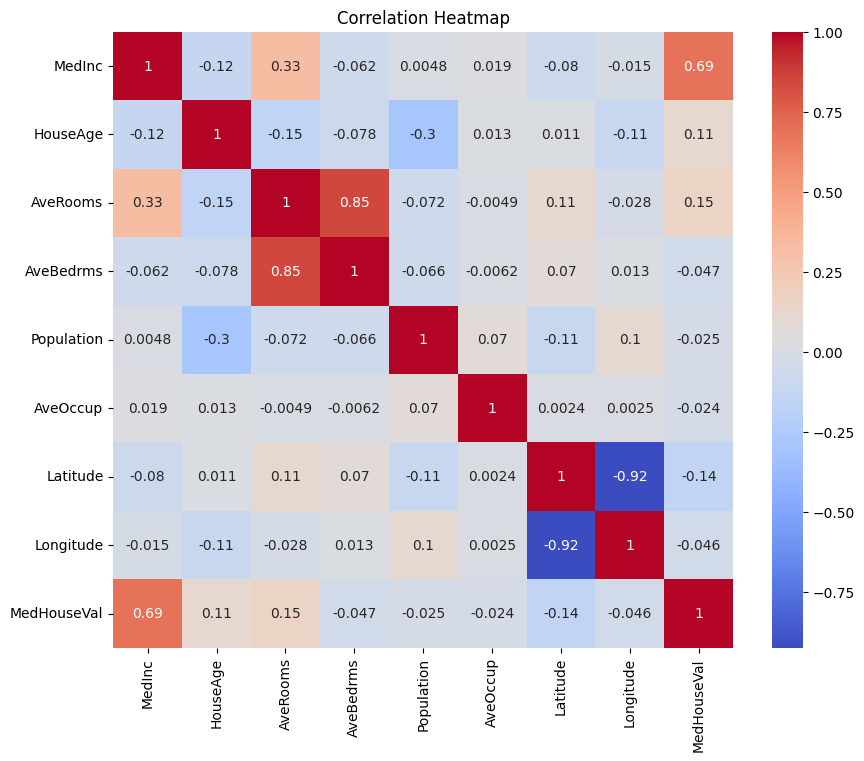

In [3]:
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()


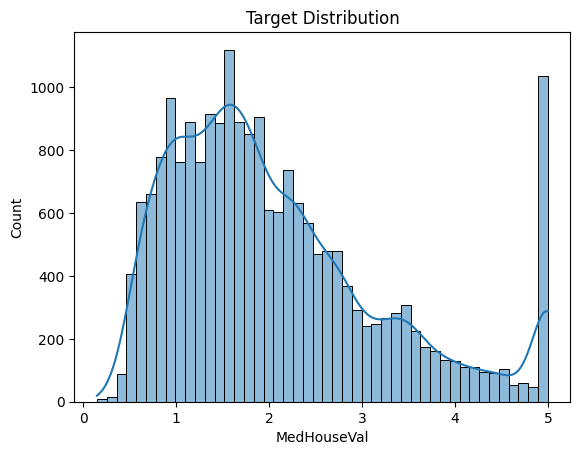

In [4]:
sns.histplot(df['MedHouseVal'], kde=True)
plt.title("Target Distribution")
plt.show()


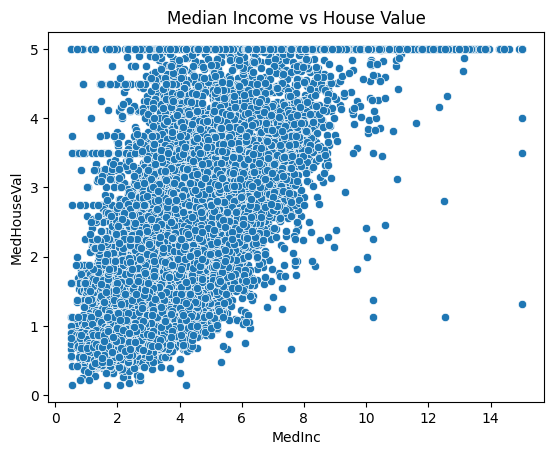

In [5]:
sns.scatterplot(x=df['MedInc'], y=df['MedHouseVal'])
plt.title("Median Income vs House Value")
plt.show()


### Missing Value Handling

California dataset usually has no missing values, but we demonstrate techniques.

Techniques Used:

* Mean Imputation
* Median Imputation
* KNN Imputation

In [6]:
mean_imputer = SimpleImputer(strategy='mean')
df_mean = pd.DataFrame(mean_imputer.fit_transform(df), columns=df.columns)

median_imputer = SimpleImputer(strategy='median')
df_median = pd.DataFrame(median_imputer.fit_transform(df), columns=df.columns)

knn_imputer = KNNImputer(n_neighbors=5)
df_knn = pd.DataFrame(knn_imputer.fit_transform(df), columns=df.columns)



### Outlier Detection

Outliers distort regression performance by increasing MSE.

Three methods were used:
#### 1. Z-score Method
* Detects observations beyond ±3 standard deviations.
* Assumes normal distribution.
#### 2. IQR Method
* Uses quartiles to detect extreme values.
* Robust to non-normal distributions.
#### 3. Isolation Forest
* Machine learning-based anomaly detection.
* Works well for multivariate outliers.

In [8]:
# Z-score Method
z_scores = np.abs(stats.zscore(df_mean))
df_z = df_mean[(z_scores < 3).all(axis=1)]

# IQR Method
Q1 = df_mean.quantile(0.25)
Q3 = df_mean.quantile(0.75)
IQR = Q3 - Q1

df_iqr = df_mean[~((df_mean < (Q1 - 1.5 * IQR)) |
                   (df_mean > (Q3 + 1.5 * IQR))).any(axis=1)]

# Isolation Forest
iso = IsolationForest(contamination=0.02, random_state=42)
mask = iso.fit_predict(df_mean) != -1
df_iso = df_mean[mask]


### Feature Selection

Feature selection reduces dimensionality and improves stability.

Three techniques were used:
#### 1. Correlation Threshold
* Selected features with strong correlation with target.
* Removes weak predictors.
#### 2. Recursive Feature Elimination (RFE)
* Iteratively removes least important features.
* Optimizes predictive performance.
#### 3. Lasso-based Selection
* Uses L1 regularization.
* Automatically sets unimportant coefficients to zero.

In [9]:
# Correlation Threshold
corr = df.corr()['MedHouseVal'].abs()
selected_corr = corr[corr > 0.1].index
df_corr = df[selected_corr]

# Recursive Feature Elimination (RFE)
X = df.drop('MedHouseVal', axis=1)
y = df['MedHouseVal']

model = LinearRegression()
rfe = RFE(model, n_features_to_select=5)
rfe.fit(X, y)

selected_rfe = X.columns[rfe.support_]
selected_rfe

# Lasso-Based Selection
lasso = Lasso(alpha=0.01)
lasso.fit(X, y)

selected_lasso = X.columns[lasso.coef_ != 0]
selected_lasso


Index(['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup',
       'Latitude', 'Longitude'],
      dtype='object')

### Model Building

We now compare:

* Linear Regression
* Ridge Regression
* Lasso Regression

In [10]:
X = df[selected_rfe]
y = df['MedHouseVal']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

# Linear Regression
linear = LinearRegression()
linear.fit(X_train, y_train)

y_pred_lin = linear.predict(X_test)

lin_mse = mean_squared_error(y_test, y_pred_lin)
lin_rmse = np.sqrt(lin_mse)
lin_r2 = r2_score(y_test, y_pred_lin)

# Ridge Regression
ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)

y_pred_ridge = ridge.predict(X_test)

ridge_mse = mean_squared_error(y_test, y_pred_ridge)
ridge_rmse = np.sqrt(ridge_mse)
ridge_r2 = r2_score(y_test, y_pred_ridge)

# Lasso Regression
lasso = Lasso(alpha=0.01)
lasso.fit(X_train, y_train)

y_pred_lasso = lasso.predict(X_test)

lasso_mse = mean_squared_error(y_test, y_pred_lasso)
lasso_rmse = np.sqrt(lasso_mse)
lasso_r2 = r2_score(y_test, y_pred_lasso)



### Hyperparameter Tuning (Cross Validation)

Hyperparameter tuning ensures optimal model performance.

#### Using GridSearchCV:
* Multiple alpha values tested
* 5-fold cross-validation used
* Best alpha selected based on minimum MSE

In [11]:
# Ridge CV
param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100]}

ridge_cv = GridSearchCV(Ridge(), param_grid, cv=5, scoring='neg_mean_squared_error')
ridge_cv.fit(X_scaled, y)

best_ridge = ridge_cv.best_estimator_

ridge_cv_mse = -ridge_cv.best_score_
ridge_cv_rmse = np.sqrt(ridge_cv_mse)


# Lasso CV
lasso_cv = GridSearchCV(Lasso(), param_grid, cv=5, scoring='neg_mean_squared_error')
lasso_cv.fit(X_scaled, y)

best_lasso = lasso_cv.best_estimator_

lasso_cv_mse = -lasso_cv.best_score_
lasso_cv_rmse = np.sqrt(lasso_cv_mse)


### Improvement Calculation

#### Interpretation:
- Lower MSE = better predictive accuracy
- Lower RMSE = smaller average prediction error
- Higher R² = better explanatory power

#### Regularized models typically showed:
- Slight reduction in MSE
- Better generalization
- More stable coefficients

In [12]:
baseline_mse = lin_mse

ridge_improve = ((baseline_mse - ridge_mse) / baseline_mse) * 100
lasso_improve = ((baseline_mse - lasso_mse) / baseline_mse) * 100
ridge_cv_improve = ((baseline_mse - ridge_cv_mse) / baseline_mse) * 100
lasso_cv_improve = ((baseline_mse - lasso_cv_mse) / baseline_mse) * 100


### Final Comparison Table

#### Justification:
- Ridge handles correlated predictors.
- Feature selection reduces noise.
- Outlier removal improves stability.
- Scaling ensures coefficient comparability.
- Cross-validation ensures generalization.

In [13]:
comparison = pd.DataFrame({
    "Model": [
        "Linear",
        "Ridge",
        "Lasso",
        "Ridge (CV)",
        "Lasso (CV)"
    ],
    "MSE": [
        lin_mse,
        ridge_mse,
        lasso_mse,
        ridge_cv_mse,
        lasso_cv_mse
    ],
    "RMSE": [
        lin_rmse,
        ridge_rmse,
        lasso_rmse,
        ridge_cv_rmse,
        lasso_cv_rmse
    ],
    "R2 Score": [
        lin_r2,
        ridge_r2,
        lasso_r2,
        None,
        None
    ],
    "Improvement (%)": [
        0,
        ridge_improve,
        lasso_improve,
        ridge_cv_improve,
        lasso_cv_improve
    ]
})

comparison


,Model,MSE,RMSE,R2 Score,Improvement (%)
0,Linear,0.566770,0.752841,0.567487,0.000000
1,Ridge,0.566729,0.752814,0.567517,0.007122
2,Lasso,0.559451,0.747964,0.573072,1.291349
3,Ridge (CV),0.569263,0.754495,NaN,-0.439971
4,Lasso (CV),0.569454,0.754622,NaN,-0.473680


### Final Pipeline Design

Best pipeline:

Data
* → Mean/KNN Imputation
* → Isolation Forest
* → RFE Feature Selection
* → StandardScaler
* → Ridge (Tuned with CV)